In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
transactions = pd.read_csv("transactions_data_cleaned.csv")
customers = pd.read_csv("customers_data_cleaned.csv")
products = pd.read_csv("products_data_cleaned.csv")

In [3]:
transactions['Transaction_Date'] = pd.to_datetime(transactions['Transaction_Date'])

In [4]:
customer_features = transactions.groupby('Company_ID').agg(
    Total_Spending=('Total_Cost', 'sum'),
    Transaction_Frequency=('Transaction_ID', 'count')
).reset_index()

In [6]:
if 'Quantity' not in transactions.columns:
    transactions['Quantity'] = 1

In [7]:
avg_quantity = transactions.groupby('Company_ID')['Quantity'].mean().reset_index()
customer_features = customer_features.merge(avg_quantity, on='Company_ID', how='left')
customer_features.rename(columns={'Quantity': 'Avg_Quantity_Purchased'}, inplace=True)

In [8]:
customer_features = customer_features.merge(customers[['Company_ID', 'Company_Profit']], on='Company_ID', how='left')

In [9]:
customer_features['Likelihood to recommend'] = np.interp(
    customer_features['Total_Spending'], 
    (customer_features['Total_Spending'].min(), customer_features['Total_Spending'].max()), 
    (1, 10)
) + np.interp(
    customer_features['Transaction_Frequency'], 
    (customer_features['Transaction_Frequency'].min(), customer_features['Transaction_Frequency'].max()), 
    (1, 10)
)

In [10]:
customer_features['Satisfaction rating'] = np.interp(
    customer_features['Total_Spending'], 
    (customer_features['Total_Spending'].min(), customer_features['Total_Spending'].max()), 
    (1, 5)
) + np.interp(
    customer_features['Avg_Quantity_Purchased'], 
    (customer_features['Avg_Quantity_Purchased'].min(), customer_features['Avg_Quantity_Purchased'].max()), 
    (1, 5)
)

In [11]:
customer_features['Likelihood to recommend'] = customer_features['Likelihood to recommend'].clip(1, 10).round(2)
customer_features['Satisfaction rating'] = customer_features['Satisfaction rating'].clip(1, 5).round(2)
customer_features['Total_Spending'] = customer_features['Total_Spending'].round(2)
customer_features['Avg_Quantity_Purchased'] = customer_features['Avg_Quantity_Purchased'].round(2)
customer_features['Company_Profit'] = customer_features['Company_Profit'].round(2)

In [12]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop(columns=['Company_ID']))

In [13]:
inertia = []
k_range = range(1, 11)

In [14]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

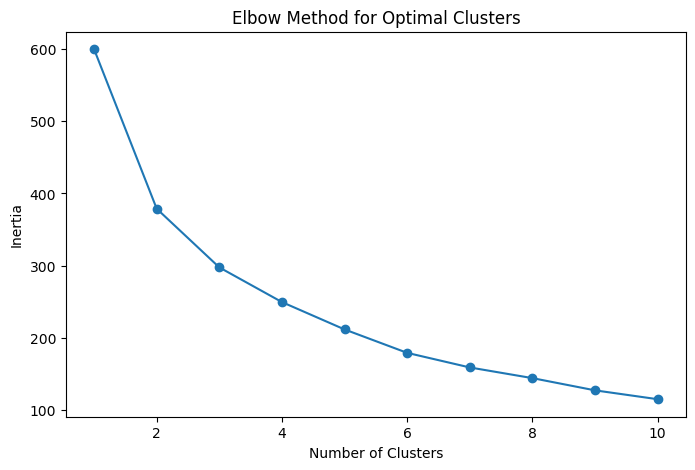

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [16]:
k_optimal = 4  # Replace with the actual optimal value found from the plot
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

In [17]:
segment_map = {
    0: 'Low Spenders - Low Frequency',
    1: 'High Spenders - High Frequency',
    2: 'Moderate Spenders - Satisfied',
    3: 'Unhappy Customers - High Spending'
}  # Adjust based on analysis
customer_features['Segment'] = customer_features['Cluster'].map(segment_map)

In [18]:
most_purchased_products = transactions.groupby(['Company_ID', 'Product_ID'])['Transaction_ID'].count().reset_index()
most_purchased_products = most_purchased_products.sort_values(by=['Company_ID', 'Transaction_ID'], ascending=[True, False])
customer_recommendations = most_purchased_products.groupby('Company_ID').first().reset_index()

In [19]:
customer_recommendations = customer_recommendations.merge(products[['Product_ID', 'Product_Name']], on='Product_ID', how='left')
customer_recommendations.drop(columns=['Product_ID'], inplace=True)  # Remove Product ID, keep Product Name

In [20]:
final_output = customer_features.merge(customer_recommendations[['Company_ID', 'Product_Name']], on='Company_ID', how='left')

In [23]:
encoder = LabelEncoder()
final_output['Product_Name_Encoded'] = encoder.fit_transform(final_output['Product_Name'].astype(str))

In [24]:
final_output.to_csv("customer_feature_engineered.csv", index=False)